# Cats and dogs with pretrained convnet (I - no data augmentation)

The code has been changed with respect to the book according to:
- https://keras.io/applications/#vgg16
- https://forums.manning.com/posts/list/42880.page

In the book the rescaling of the images for vgg16 is wrong. There the accuracy was ~90%, with the changing it is ~ 95%

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt

#from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


### Define folders

In [2]:
base_dir = './cats_and_dogs_small/'

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Load pretrained convnet

In [4]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Extract features

In [6]:
#Note: the correct way to rescale image for vgg16 is using "preprocess_input" and not
#datagen = ImageDataGenerator(rescale=1./255)

# vgg16 was trained on images of size 224 × 244, preprocessed according to a few rules that are packaged in
# the utility function keras.applications.vgg16.preprocess_input .

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 10

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    del generator, features_batch
    
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [9]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [10]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


### The extracted features are currently of shape (samples, 4, 4, 512); we feed them to a densely connected classifier, so we flatten them to (samples, 8192)

In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Define your densely connected classifier

In [12]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))

#for regularisation
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [14]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 268us/step - loss: 3.8460 - acc: 0.6785 - val_loss: 0.9001 - val_acc: 0.9070
Epoch 2/30
2000/2000 [==============================] - 0s 141us/step - loss: 1.4513 - acc: 0.8645 - val_loss: 0.5401 - val_acc: 0.9470
Epoch 3/30
2000/2000 [==============================] - 0s 140us/step - loss: 1.1698 - acc: 0.8955 - val_loss: 0.5308 - val_acc: 0.9470
Epoch 4/30
2000/2000 [==============================] - 0s 140us/step - loss: 0.7287 - acc: 0.9255 - val_loss: 0.4766 - val_acc: 0.9520
Epoch 5/30
2000/2000 [==============================] - 0s 141us/step - loss: 0.6867 - acc: 0.9345 - val_loss: 0.3812 - val_acc: 0.9570
Epoch 6/30
2000/2000 [==============================] - 0s 141us/step - loss: 0.5106 - acc: 0.9540 - val_loss: 0.4061 - val_acc: 0.9620
Epoch 7/30
2000/2000 [==============================] - 0s 141us/step - loss: 0.5155 - acc: 0.9485 - val_loss: 0.3776 - val_acc: 0.9620


# Plots

###  These figures are dfferent with respect to the book (figs. 5.15 and 5.16), because I am now using "preprocess_input"

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

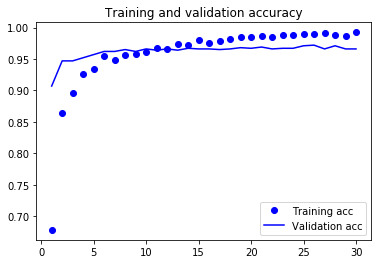

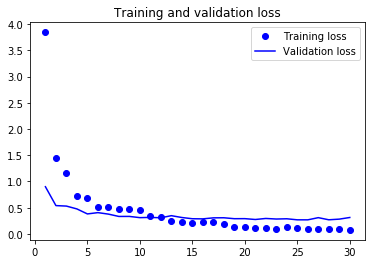

In [16]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Note: in the book it is shown a strong overfitting despite dropout because there is no data augmentation. After the correct preprocessing the strong overfitting is not present and probably data augmentation will have no effect. 